# Convex unmixer

Notebook that uses a network representation of sample localities to unmix sedimentary geochemical data. 

## Declarations

In [1]:
import pyfastunmix
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from typing import Dict

In [2]:
def add_concentrations(a: Dict[str, cp.Variable], b: Dict[str, cp.Variable]) -> Dict[str, cp.Variable]:
    """Add two dictionaries together"""
    temp: Dict[str, cp.Variable] = {}
    for e in a.keys():
        assert e in b.keys(), f"Key {e} from dictionary a was not found in dictionary b!"
        temp[e] = a[e] + b[e]
    return temp

## Defining the graph 

In [3]:
# Get the graph representations of the data
sample_network, sample_adjacency = pyfastunmix.fastunmix("data/")
G = nx.DiGraph()
for i, node_data in enumerate(sample_network):
  if i==0:
    continue
  G.add_node(i, data=node_data)
  if node_data.downstream_node != 0:
    G.add_edge(i, node_data.downstream_node)

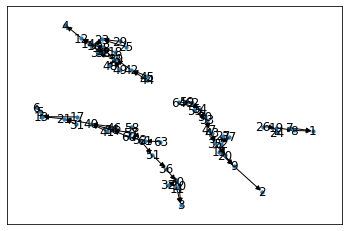

In [4]:
nx.draw_networkx(G,arrows=True,with_labels=True,node_size=10)
plt.show()

In [5]:
elements = ['Li', 'Be', 'Na', 'Mg', 'Al', 'P', 'K', 'Ca', 'Ti', 'V',
       'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'As', 'Se', 'Rb', 'Sr',
       'Y', 'Zr', 'Nb', 'Mo', 'Ag', 'Cd', 'Sn', 'Sb', 'Cs', 'Ba', 'La', 'Ce',
       'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
       'Hf', 'Ta', 'W', 'Tl', 'Pb', 'Th', 'U']

elements = ['Mg']

# Code from the notebook
geochem_raw = np.loadtxt('data/geochem.dat',dtype=str) # Read in data
geochem_raw = np.delete(geochem_raw,[7,53],1) # Delete columns for S and Bi (too many NAs)
elems = geochem_raw[0,1:54] # List of element strings
obs_data = pd.DataFrame(geochem_raw[1:,],columns=geochem_raw[0,:]) # Cast to DataFrame for quick access
obs_data[elems]=obs_data[elems].astype(float) # Cast numeric data to float

## Defining total area for every node

In [6]:
for x in nx.topological_sort(G):
    my_data = G.nodes[x]['data']
    print(f"Processing {my_data.data.name}...")
    my_data.total_area += my_data.area
    if my_data.downstream_node!=0: # If node has downstream nodes
        downstream_data = G.nodes[my_data.downstream_node]['data']
        downstream_data.total_area += my_data.total_area

Processing CG003...
Processing CG045...
Processing CG061...
Processing CG025...
Processing CG057...
Processing CG059...
Processing CG097...
Processing CG005...
Processing CG008_rep_avg...
Processing CG030_rep_avg...
Processing CG041...
Processing CG065...
Processing CG064...
Processing CG066...
Processing CG043_rep_avg...
Processing CG063...
Processing CG033...
Processing CG016...
Processing CG099...
Processing CG096...
Processing CG044...
Processing CG007...
Processing CG011...
Processing CG019...
Processing CG094...
Processing CG100...
Processing CG098...
Processing CG062...
Processing CG020...
Processing CG026...
Processing CG015...
Processing CG049...
Processing CG089...
Processing CG087...
Processing CG022...
Processing CG051...
Processing CG023...
Processing CG093...
Processing CG084...
Processing CG048...
Processing CG010...
Processing CG073...
Processing CG042...
Processing CG031...
Processing CG079...
Processing CG053...
Processing CG036...
Processing CG075...
Processing CG068

## Building an objective function

In [7]:
# Build the main objective
# Use a topological sort to ensure upstream-to-downstream motion.
primary_terms = []
for x in nx.topological_sort(G):
    my_data = G.nodes[x]['data']
#     print(f"Processing {my_data.data.name}...")
    my_data.my_values = {e : cp.Variable(pos=True) for e in elements} # Set up a CVXPY parameter for each element for each node
    my_data.my_flux = {e : my_data.area * v for e, v in my_data.my_values.items()} # area weighted contribution from this node
    if hasattr(my_data, "total_flux"): # If node already receives flux, add this node's contribution to that
        my_data.total_flux = add_concentrations(my_data.my_flux, my_data.total_flux)
    else: # If leaf node, set the total flux leaving node as the contribution from this node only
        my_data.total_flux = my_data.my_flux

    for element, concentration in my_data.total_flux.items():
        observed = float(obs_data[obs_data["Sample.Code"]==my_data.data.name][element])
        normalised_concentration = concentration/my_data.total_area
        primary_terms.append(cp.maximum(normalised_concentration/observed,observed*cp.inv_pos(normalised_concentration)))
    if my_data.downstream_node!=0: # If node has downstream nodes
        downstream_data = G.nodes[my_data.downstream_node]['data']
        if hasattr(downstream_data, "total_flux"):
            # If downstream node already receives flux, add this nodes flux to it 
            downstream_data.total_flux = add_concentrations(my_data.total_flux, downstream_data.total_flux)
        else:
            # If not, set the flux received downstream just as the contribution from this node
            downstream_data.total_flux = my_data.total_flux

In [8]:
objective = cp.norm(cp.vstack(primary_terms))
constraints = []
# Create and solve the problem
print("Compiling and solving problem...")
problem = cp.Problem(cp.Minimize(objective), constraints)
objective_value = problem.solve(verbose=True)

print(f"Problem status = {problem.status}")
print(f"Objective value = {objective_value}")

Compiling and solving problem...

ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +2e+03  8e-01  4e-01  1e+00  8e+00    ---    ---    1  1  - |  -  - 
 1  +3.541e+01  +3.726e+01  +1e+03  6e-01  4e-01  3e+00  5e+00  0.5178  3e-01   2  2  2 |  0  0
 2  +3.616e+01  +3.700e+01  +3e+02  1e-01  9e-02  1e+00  1e+00  0.8413  6e-02   2  2  1 |  0  0
 3  +6.457e+01  +6.633e+01  +2e+02  1e-01  1e-01  2e+00  7e-01  0.5711  4e-01   2  2  2 |  0  0
 4  +9.308e+01  +9.437e+01  +4e+01  4e-02  4e-02  1e+00  2e-01  0.7795  3e-02   2  1  2 |  0  0
 5  +8.518e+01  +8.623e+01  +2e+01  3e-02  3e-02  1e+00  8e-02  0.5941  1e-01   1  1  1 |  0  0
 6  +8.172e+01  +8.287e+01  +2e+01  3e-02  3e-02  1e+00  7e-02  0.2474  7e-01   1  1  1 |  0  0
 7  +8.332e+01  +8.427e+01  +4e+00  1e-02  1e-02  1e+00  2e-02  0.8090  4e-02   1  2  1 |  0  0
 8  +8.145e+0

/home/alex/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [9]:
# Print the solution we found
pred = []
obs = []
names = []
for x in G.nodes:
    data = G.nodes[x]['data']
    sample_name = data.data.name
    node_total_area = my_data.total_area
    if not hasattr(data, "my_values"):
        continue
    for element, flux in data.total_flux.items():
        pred=pred+[flux.value/node_total_area]
    observed = float(obs_data[obs_data["Sample.Code"]==data.data.name][element])
    names = names + [sample_name]
#     print("Pred",flux.value/node_total_area)
#     print("Obs",observed)
    obs=obs+[observed]

In [10]:
np.array([names,pred,obs]).T

array([['CG090', '5537.950482183616', '12137.0'],
       ['CG039', '8652.035932313891', '7068.0'],
       ['CG021', '5393.441062161276', '14289.0'],
       ['CG013', '18789.71510507569', '10268.0'],
       ['CG088', '6648.921042641616', '8466.0'],
       ['CG032', '496.492685535362', '8354.0'],
       ['CG001', '1058.1996300517253', '7501.0'],
       ['CG068_rep_avg', '3953.724258570638', '16021.0'],
       ['CG091', '8262.710755361091', '6152.0'],
       ['CG023', '3473.5484570823164', '14487.0'],
       ['CG024', '1319.0430437531181', '21039.0'],
       ['CG095', '17647.26450159373', '10230.0'],
       ['CG092_rep_avg', '5787.731238052851', '9618.5'],
       ['CG089', '12297.67554791527', '7100.0'],
       ['CG077', '489.82696243163815', '22709.0'],
       ['CG085', '5329.397232401543', '9622.0'],
       ['CG002', '767.7285229237569', '5133.0'],
       ['CG035', '2913.0418632110936', '11078.0'],
       ['CG075', '3340.1269442835464', '21015.0'],
       ['CG042', '7341.361610044791', 

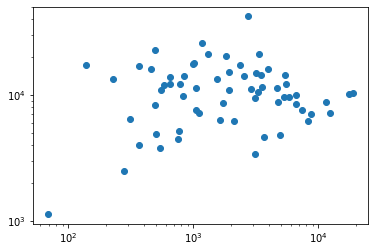

In [11]:
plt.scatter(pred,obs)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')